### Description

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. <br>

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! <br>

### Evaluation
Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). <br>
Any day and store with 0 sales is ignored in scoring.

### Data Fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.
<br>
__Id__ - an Id that represents a (Store, Date) duple within the test set <br>
__Store__ - a unique Id for each store <br>
__Sales__ - the turnover for any given day (this is what you are predicting) <br>
__Customers__ - the number of customers on a given day <br>
__Open__ - an indicator for whether the store was open: 0 = closed, 1 = open <br>
__StateHoliday__ - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None <br>
__SchoolHoliday__ - indicates if the (Store, Date) was affected by the closure of public schools <br>
__StoreType__ - differentiates between 4 different store models: a, b, c, d <br>
__Assortment__ - describes an assortment level: a = basic, b = extra, c = extended <br>
__CompetitionDistance__ - distance in meters to the nearest competitor store <br>
__CompetitionOpenSince[Month/Year]__ - gives the approximate year and month of the time the nearest competitor was opened <br>
__Promo__ - indicates whether a store is running a promo on that day <br>
__Promo2__ - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating <br>
__Promo2Since[Year/Week]__ - describes the year and calendar week when the store started participating in Promo2 <br>
__PromoInterval__ - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/pavelbryantsev/Desktop/Python/Courses/Gleb/Projects/rossma_store_sales_prediction/rossmann-store-sales/train.csv')
df_store = pd.read_csv('/Users/pavelbryantsev/Desktop/Python/Courses/Gleb/Projects/rossma_store_sales_prediction/rossmann-store-sales/store.csv')

Merging two datasets

In [3]:
data = df.merge(df_store, on='Store', how='inner')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

# Exploratory Data Analysis

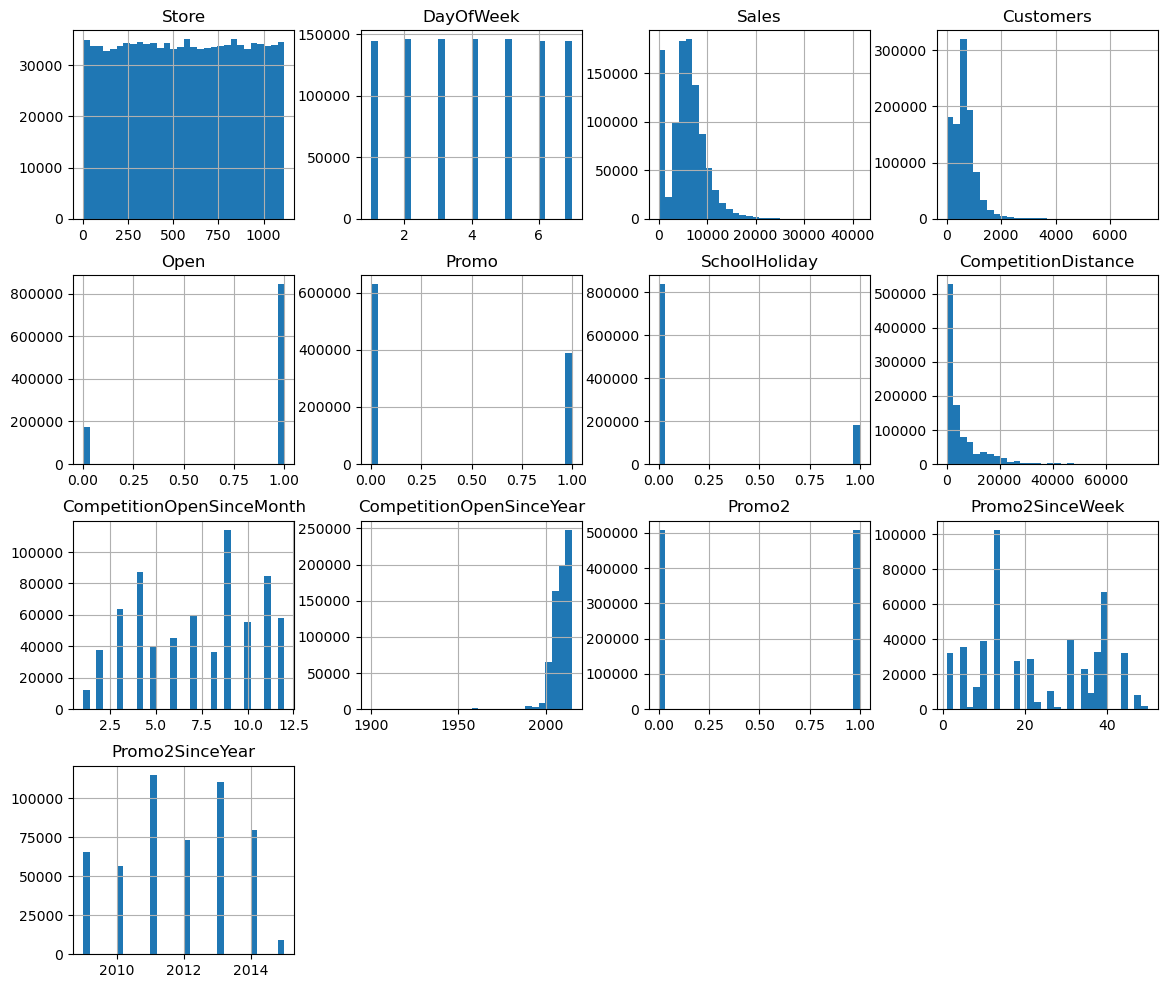

In [5]:
data.hist(figsize=(14, 12), bins=30);

### Extracting data from Date

Since we are working with timeseries data we maight want to extract "Year, month and day of the week" from the date column, to see if this has any effect on sales. 

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

In [7]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['WeekOfYear'] = data['Date'].dt.isocalendar().week
data['DayOfWeek'] = data['Date'].dt.dayofweek

Lets explore stores that were open or closed and their sales. 

In [8]:
data[(data.Open != 0) & (data.Sales == 0)].shape

(54, 22)

It seems like there were days when some stores were open but had any sales.

We are only intersted in stores that were open. Will drop the rest 

In [9]:
data = data[data['Open'] != 0]

## Dealing with missing values

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017207
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int32         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        842206 non-null  float64     

If there is no Promo2 then there is no information about it. We can replace these values with 0. The same goes for CompetitionOpenSinceMonth and CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear, PromoInterval.

In [11]:
data.CompetitionOpenSinceMonth = data.CompetitionOpenSinceMonth.fillna(0)
data.CompetitionOpenSinceYear = data.CompetitionOpenSinceYear.fillna(0)
data.Promo2SinceWeek = data.Promo2SinceWeek.fillna(0)
data.Promo2SinceYear = data.Promo2SinceYear.fillna(0)
data.PromoInterval = data.PromoInterval.fillna(0)

In [12]:
data.isna().mean()

Store                        0.000000
DayOfWeek                    0.000000
Date                         0.000000
Sales                        0.000000
Customers                    0.000000
Open                         0.000000
Promo                        0.000000
StateHoliday                 0.000000
SchoolHoliday                0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002589
CompetitionOpenSinceMonth    0.000000
CompetitionOpenSinceYear     0.000000
Promo2                       0.000000
Promo2SinceWeek              0.000000
Promo2SinceYear              0.000000
PromoInterval                0.000000
Year                         0.000000
Month                        0.000000
Day                          0.000000
WeekOfYear                   0.000000
dtype: float64

Since we are only having 0.2% of missing data in CompetitionDistance column we can just drop those rows.

In [13]:
data.dropna(inplace=True)

In [14]:
data.groupby('StoreType')['Date'].agg(['min', 'max'])

,min,max
StoreType,,
a,2013-01-01,2015-07-31
b,2013-01-01,2015-07-31
c,2013-01-02,2015-07-31
d,2013-01-02,2015-07-31


### Exploring Store Types

In [15]:
data.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,456293.0,6929.647347,3278.470505,0.0,4700.0,6290.0,8412.0,41551.0
b,15563.0,10231.407505,5157.190155,0.0,6344.0,9130.0,13183.5,38722.0
c,112978.0,6932.512755,2897.564578,0.0,4915.0,6407.0,8349.0,31448.0
d,257372.0,6825.895575,2553.669461,0.0,5056.0,6397.0,8124.0,38037.0


Store Type B - has the highest average sales among others. 
Lets see total sales

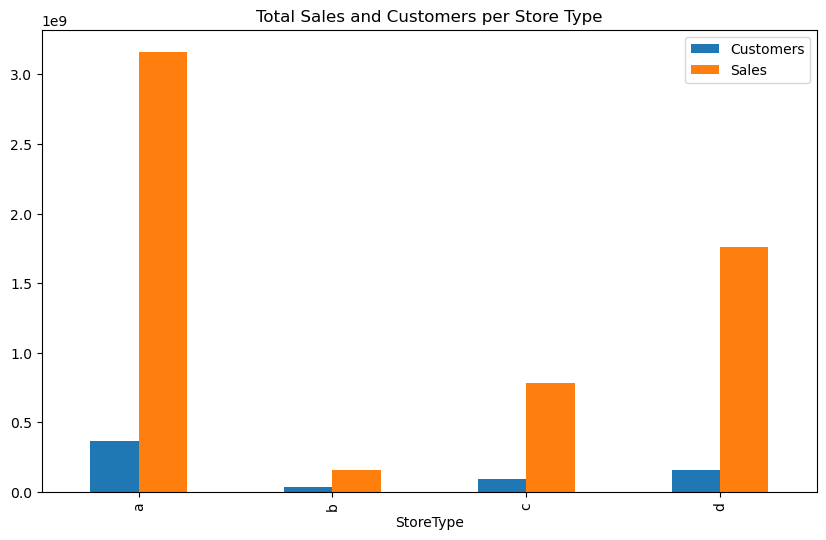

In [16]:
data.groupby('StoreType')[['Customers', 'Sales']].sum().plot.bar(figsize=(10, 6), title='Total Sales and Customers per Store Type');

Clearly Store Type A has the most __sales__ and __customer count__.

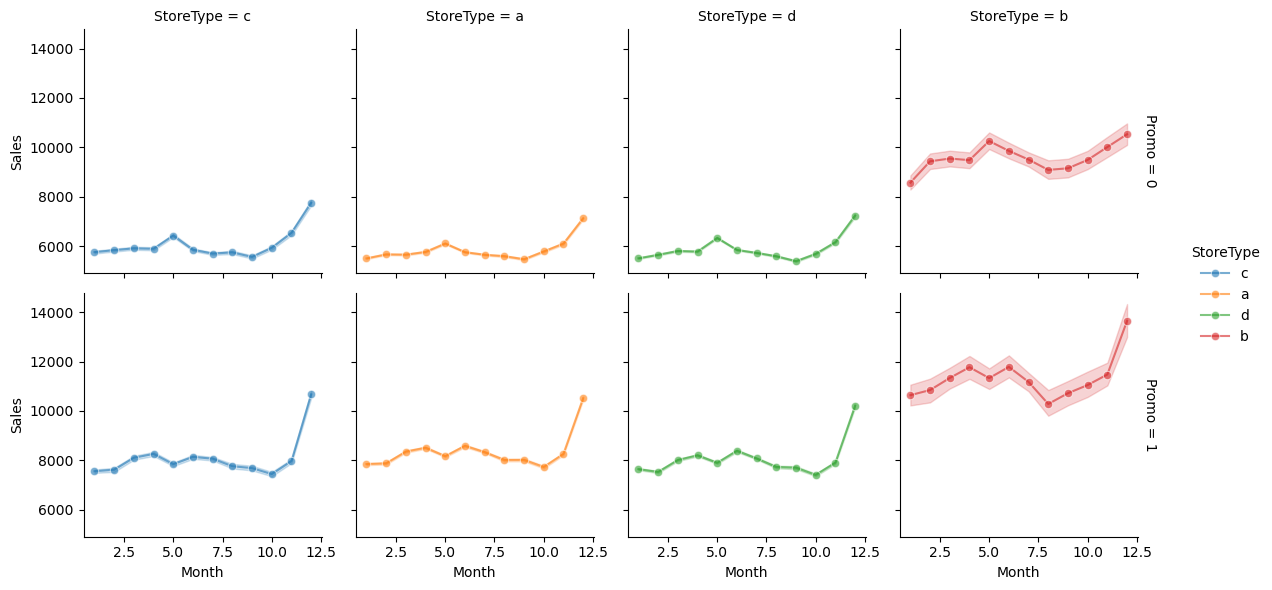

In [17]:
g = sns.FacetGrid(data = data, 
               col = 'StoreType',
               hue = 'StoreType',
               row = 'Promo',
               margin_titles = True
               )
g.map(sns.lineplot, 'Month', 'Sales', alpha = .6, marker = 'o').add_legend();

Looks like sales have a patern to go up during winter holidays. Same with number of customers

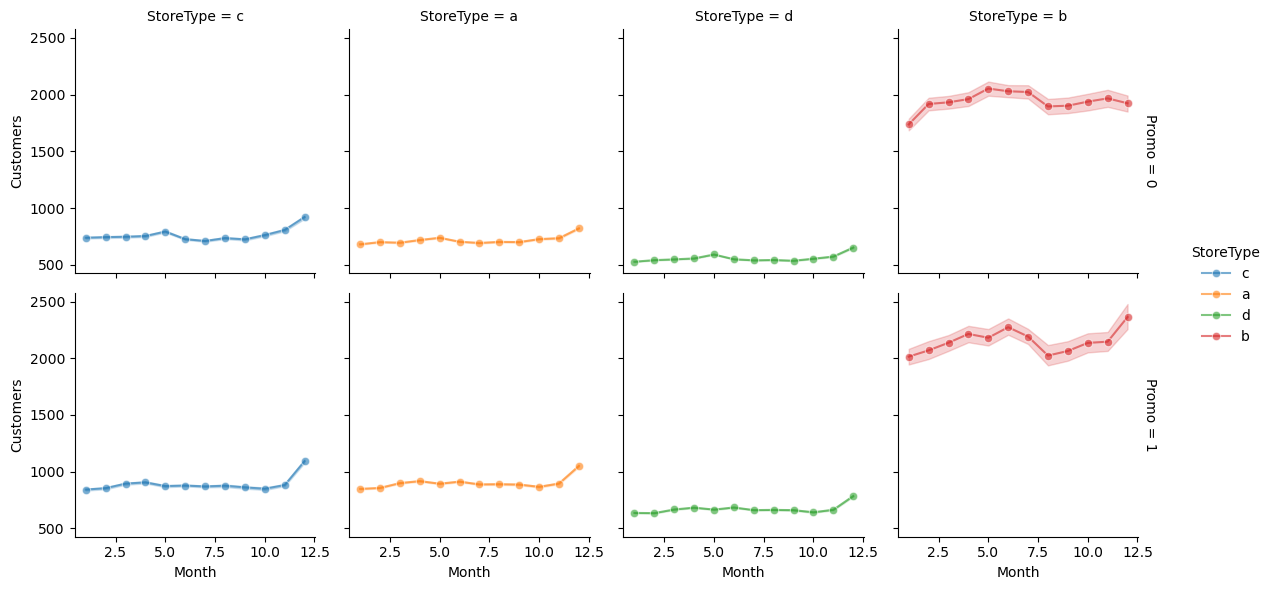

In [18]:
g = sns.FacetGrid(data = data, 
               col = 'StoreType',
               hue = 'StoreType',
               row = 'Promo',
               margin_titles = True
               )
g.map(sns.lineplot, 'Month', 'Customers', alpha = .6, marker = 'o').add_legend();

Scale of customer count and sales are different depending on promotion. Sales are higher when Store has a promotion 

We have two likely correlated variables in the dataset, which we can combine into our dataset. 
Create a new column 'SalesPerCustomer' to explore the behavior of customers average check. 

In [19]:
data['SalesPerCustomer'] = data['Sales'] / data['Customers']

In [20]:
print(f'Sale per customer: mean: {data["SalesPerCustomer"].mean():.2f} USD, min: {data["SalesPerCustomer"].min():.2f} USD, max: {data["SalesPerCustomer"].max():.2f} USD')
data['SalesPerCustomer'].describe()

Sale per customer: mean: 9.49 USD, min: 0.00 USD, max: 64.96 USD


count    842154.000000
mean          9.492349
std           2.199501
min           0.000000
25%           7.892091
50%           9.246719
75%          10.900885
max          64.957854
Name: SalesPerCustomer, dtype: float64

On average a customer spends $9.50, but we can observe that there are days when customer spending is 0.

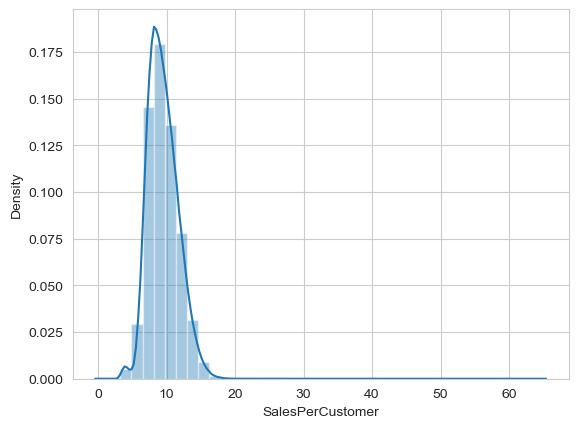

In [21]:
sns.set_style('whitegrid')
sns.distplot(data['SalesPerCustomer'],
             bins = 40,
             kde = True);


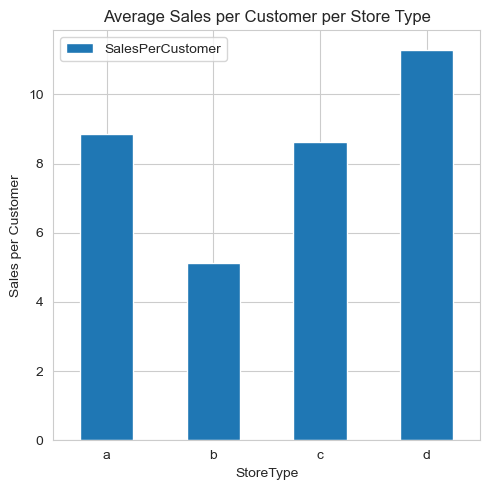

In [22]:
data.groupby('StoreType')[['SalesPerCustomer']].mean().plot.bar(figsize=(5, 5),
                                                                title='Average Sales per Customer per Store Type')
plt.ylabel('Sales per Customer')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
data.groupby('StoreType')[['SalesPerCustomer', 'Customers']].mean()

,SalesPerCustomer,Customers
StoreType,,
a,8.844365,795.989231
b,5.133097,2021.822335
c,8.626227,815.465887
d,11.284844,606.256644


Store Type B - has on average most sales, but average SalesPerCustomer are low, but if you look at number of customers visiting this store you can get an idea why the average sales are higher compaired to the rest of stores. 

In [ ]:
g = sns.FacetGrid(data = data, 
               col = 'StoreType',
               hue = 'StoreType',
               row = 'Promo',
               margin_titles = True
               )
g.map(sns.lineplot, 'Month', 'Customers', alpha = .6, marker = 'o').add_legend();

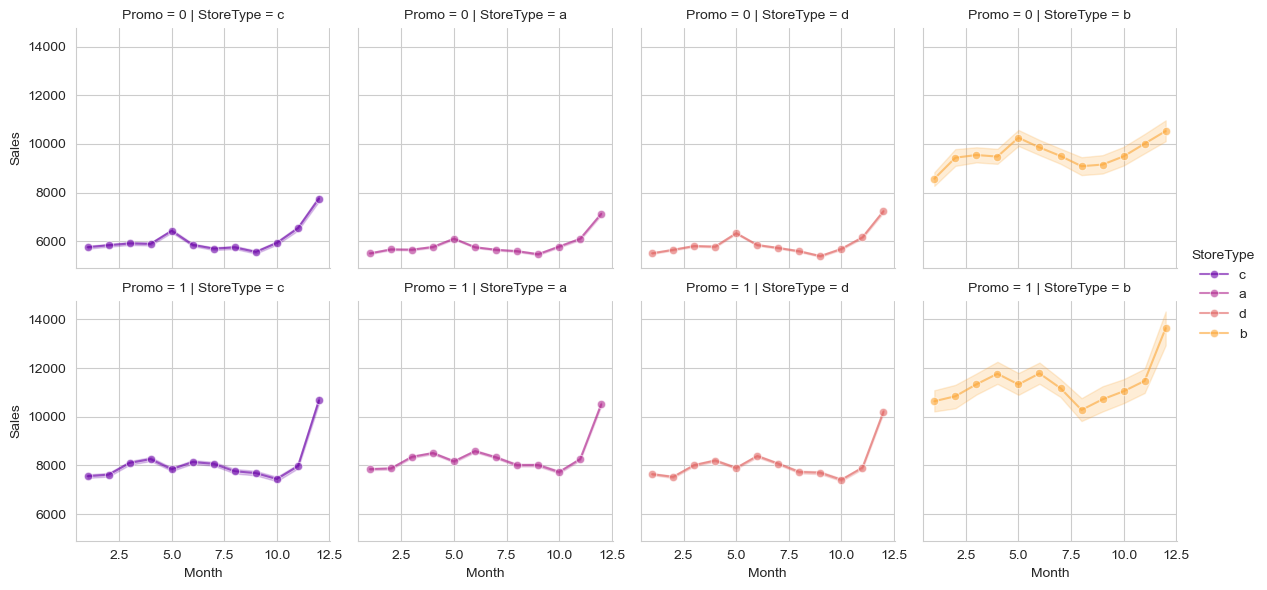

In [31]:
# sales trends
g = sns.FacetGrid(data = data, 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

g.map(sns.lineplot, 'Month', 'Sales', alpha = .6, marker = 'o').add_legend();

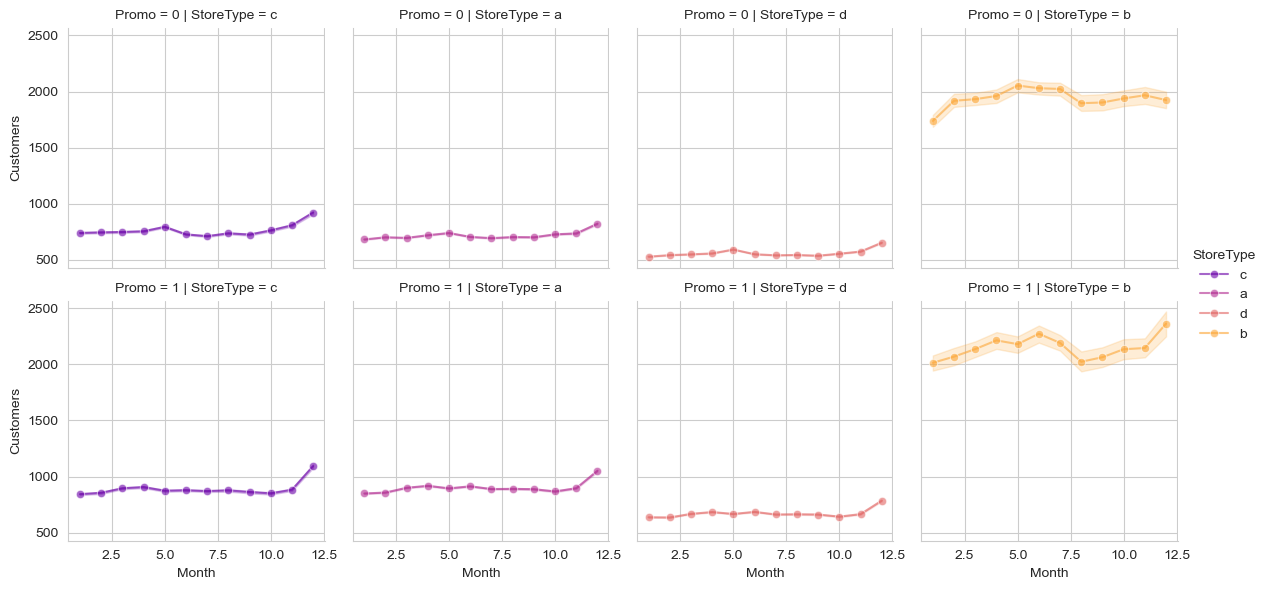

In [33]:
# sales trends
g = sns.FacetGrid(data = data, 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

g.map(sns.lineplot, 'Month', 'Customers', alpha = .6, marker = 'o').add_legend();

All store types follow the same trend but at different scales depending on the presence of the (first) promotion Promo and StoreType itself (case for B).
Sales are going up during Christmas holidays

### Lets explore stores by its Assortment

In [24]:
data.groupby(['StoreType', 'Assortment'])[['Sales']].mean()

Sales
StoreType Assortment              
a         a            6537.617613
          c            7588.371981
b         a           11133.992979
          b            8639.346322
          c           17969.556263
c         a            6834.931456
          c            7037.525130
d         a            6438.175360
          c            7043.363895

We can see that store type B has a unique Assortment 'b' which might drive it sales and number of clients

In [26]:
data.groupby('Assortment')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Assortment,,,,,,,,
a,443507.0,6622.559561,2972.396584,0.0,4614.00,6083.0,7999.0,38722.0
b,8212.0,8639.346322,3806.006716,0.0,5604.75,8081.0,11269.5,22137.0
c,390487.0,7306.514581,3184.113005,0.0,5163.00,6682.0,8708.0,41551.0


### To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:

In [34]:
# competition open time (in months)
data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    
# Promo open time
data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0

# replace NA's by 0
data.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
data.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6929.647347,795.989231,12898.431118,7086.353525
b,10231.407505,2021.822335,17199.117249,11366.961576
c,6932.512755,815.465887,12158.630388,6745.042106
d,6825.895575,606.256644,10405.438812,8946.015654


Surprisingly, StoreType A, despite being the highest-selling and most crowded, does not seem to face the highest level of competition. Instead, it is StoreType B that takes the spotlight in terms of competitive exposure, notably with the longest duration of promotional activities.

# Correlation analysis

In [39]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,SalesPerCustomer,CompetitionOpen,PromoOpen
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,0.0,0.0,0,2015,7,31,31,9.482883,82.0,24187.75
1,1,3,2015-07-30,5020,546,1,1,0,1,c,...,0.0,0.0,0,2015,7,30,31,9.194139,82.0,24187.75
2,1,2,2015-07-29,4782,523,1,1,0,1,c,...,0.0,0.0,0,2015,7,29,31,9.143403,82.0,24187.75
3,1,1,2015-07-28,5011,560,1,1,0,1,c,...,0.0,0.0,0,2015,7,28,31,8.948214,82.0,24187.75
4,1,0,2015-07-27,6102,612,1,1,0,1,c,...,0.0,0.0,0,2015,7,27,31,9.970588,82.0,24187.75


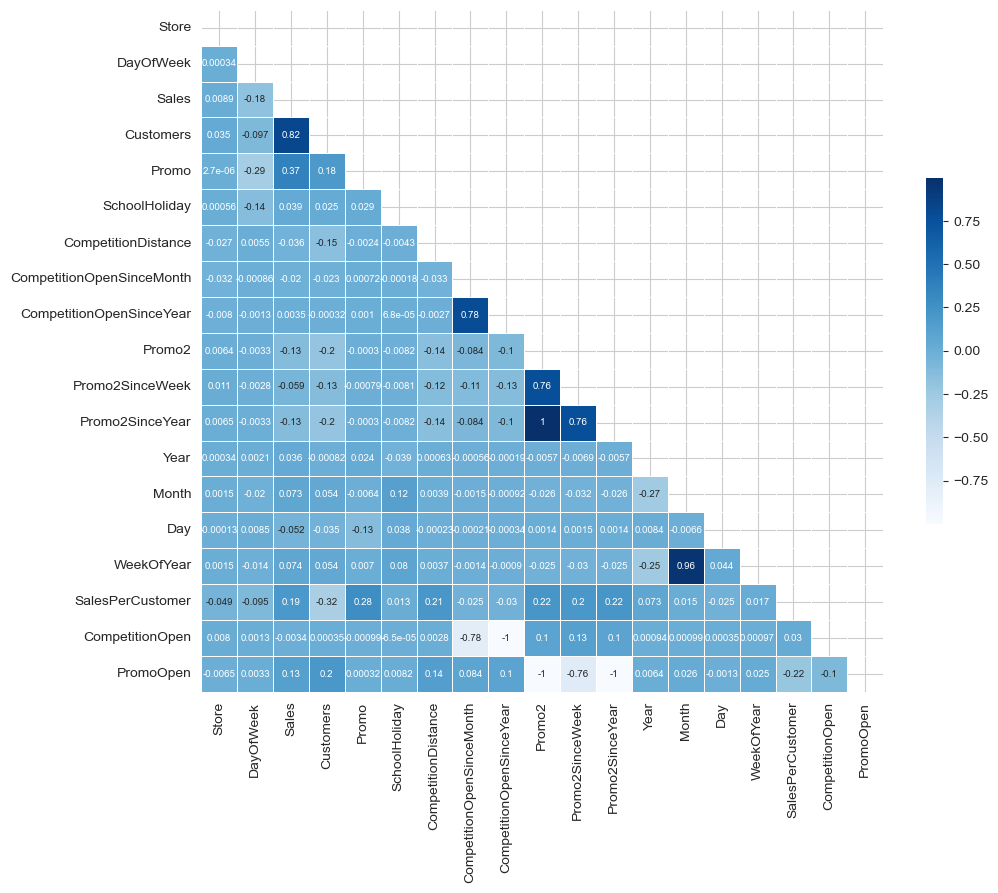

In [47]:
corr = data.select_dtypes(include='number').drop('Open', axis = 1).corr()

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5, ax=ax, cmap="Blues",
            cbar_kws={"shrink": .5},
            annot=True, annot_kws={"size": 7})      
plt.show()

As previously noted, there exists a robust positive correlation between a store's Sales and the number of Customers. Additionally, a positive correlation is evident between ongoing promotions (Promo equal to 1) and the volume of Customers. However, when a store engages in consecutive promotions (Promo2 equal to 1), the correlation with both Customers and Sales appears to plateau or even decline slightly, as reflected in the subtle negative correlation observed on the heatmap. A similar negative correlation is observed between the presence of promotions in the store and the specific day of the week.

# Conclusion of EDA

### StoreType Insights:
- StoreType A stands out as the most selling and crowded.
- StoreType D exhibits the best "Sale per Customer," suggesting a higher average buyer cart. This indicates an opportunity for Rossmann to expand its product variety to capitalize on this trend.
- StoreType B, despite having the lowest sales and customer count, shows potential. The low SalePerCustomer suggests that customers may be shopping for smaller items, presenting an opportunity for targeted improvements or promotions.

### Day-of-Week Patterns:
- Mondays witness increased customer purchases when a promotion (Promo) is in effect.
- Sundays show higher sales when there is no promotion at all (both Promo and Promo1 are equal to 0). This highlights a potential strategy for Rossmann to leverage different promotional approaches on these specific days.

### Promotional Strategies:
- Promo2 alone does not show a significant correlation with changes in sales. This suggests that this type of promotion may not be as impactful on its own, and further analysis or adjustments to the Promo2 strategy may be needed.

These insights provide valuable information for Rossmann to refine its strategies, optimize product offerings, and tailor promotions for different store types and days of the week.
